In [1]:
import os
os.chdir('../..')
!ls

product_impacts


In [2]:
import os.path
import pandas as pd
from skimpy import skim
import requests
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, mean_squared_error, r2_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from hiclass import LocalClassifierPerParentNode, LocalClassifierPerLevel

from product_impacts.product_cat.run_model import get_store, get_ndns_cats, get_products, get_ndns_matches, get_tsne

import numpy as np
import pickle
import json

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

sns.set()

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.environ["RAY_ENABLE_MAC_LARGE_OBJECT_STORE"] = "1"

In [5]:
ndns = get_ndns_cats('../../future_of_food/NDNS UK/ndns_edited.csv')
products = get_products('../../future_of_food/foodDB_23June/products.csv')
labelled_data, non_food_products = get_ndns_matches(
    ndns, products)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
# editing the lev1 category names as some lev2 categoreis have been merged across lev1 categories
ndns.loc[ndns['mainfoodgroupdesc'].isin(['Salad and other raw vegetables', 'Vegetables (not raw)']), 'mainfoodgroupdesc'] = 'Vegetables'

In [7]:
# removing duplicated product names + ingredients (basically products with same exact feature vectors)
labelled_data['product_list_name_lower'] = labelled_data['product_list_name'].str.lower()
labelled_data['ingredients_text_lower'] = labelled_data['ingredients_text'].str.lower()
labelled_data = labelled_data.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [8]:
# lev 0 predictions
predicted_data = pd.read_csv('../../future_of_food/NDNS UK/predictions/predictions_lev0_manuallabels_nonHI_RF_withcorrections_14Oct2024.csv')

In [9]:
predicted_data.shape

(262711, 11)

In [10]:
predicted_data['parentcategory_pred'].value_counts()

Cereals and Cereal Products             52426
Miscellaneous                           27598
Meat and Meat Products                  26837
Non-Alcoholic Beverages                 25994
Sugar, Preserves and Confectionery      25822
Vegetables, Potatoes                    23757
Milk and Milk Products                  23239
Alcoholic Beverages                     15150
Fish and Fish Dishes                     9302
Fruit                                    7343
Savoury Snacks                           6453
Not Food                                 5086
Nuts and Seeds                           5057
Fat Spreads                              3811
Commercial Toddlers Foods and Drinks     2488
Eggs and Egg Dishes                      1315
Dietary Supplements                       622
Artificial Sweeteners                     404
Savoury Snack                               7
Name: parentcategory_pred, dtype: int64

In [11]:
pred = predicted_data[predicted_data['parentcategory_pred']=='Vegetables, Potatoes'].reset_index(drop=True)
lab = labelled_data[(labelled_data['parentcategory']=='Vegetables, Potatoes')
                           & (labelled_data['subfoodgroupdesc'].notnull())].reset_index(drop=True)
lab = lab.merge(pred[['product_id']])

In [12]:
pred.shape

(23757, 11)

In [13]:
lab.shape

(5456, 12)

In [14]:
lab['subfoodgroupdesc'].value_counts()

Other vegetable products and dishes                              1197
Tomatoes                                                          648
Meat alternatives (including ready meals and homemade dishes)     636
Beans and pulses (including ready meal & homemade dishes)         551
Other vegetables                                                  468
Other potato products and dishes                                  458
Other fried/roast/baked potatoes                                  397
Peas                                                              268
Baked beans                                                       263
Leafy green vegetables                                            185
Chips purchased including takeaway                                167
Carrots                                                           143
Green beans                                                        75
Name: subfoodgroupdesc, dtype: int64

In [15]:
lab['mainfoodgroupdesc'].value_counts()

Vegetables (not raw)                                   3480
Salad and other raw vegetables                          954
Chips, fried and roast potatoes and potato products     564
Other potatoes, potato salads and dishes                458
Name: mainfoodgroupdesc, dtype: int64

In [16]:
pred['subfoodgroup_lab'].value_counts()

Other vegetable products and dishes                              1199
Tomatoes                                                          650
Meat alternatives (including ready meals and homemade dishes)     631
Beans and pulses (including ready meal & homemade dishes)         551
Other vegetables                                                  489
Other potato products and dishes                                  457
Other fried/roast/baked potatoes                                  398
Peas                                                              268
Baked beans                                                       263
Leafy green vegetables                                            185
Chips purchased including takeaway                                167
Carrots                                                           143
Green beans                                                        75
Meat pies and pastries                                             14
Savoury sauces pickl

In [17]:
predicted_data['subfoodgroup_lab'].nunique()

120

In [18]:
# correcting some labels
lab.loc[(lab['subfoodgroupdesc']=='Other vegetables')
        & ((lab['product_list_name'].str.lower().str.contains('pois'))
          | (lab['product_list_name'].str.lower().str.contains('peas'))),
        'subfoodgroupdesc'] = 'Peas'

lab.loc[(lab['subfoodgroupdesc']=='Other vegetables')
          & ((lab['product_list_name'].str.lower().str.contains('spinach'))
          | (lab['product_list_name'].str.lower().str.contains('chard'))
          | (lab['product_list_name'].str.lower().str.contains('kale'))
          | (lab['product_list_name'].str.lower().str.contains('cabbage'))
          | (lab['product_list_name'].str.lower().str.contains('broccoli'))
          | (lab['product_list_name'].str.lower().str.contains('asparagus'))
          | (lab['product_list_name'].str.lower().str.contains('lettuce'))
          | (lab['product_list_name'].str.lower().str.contains('rocket'))
          | (lab['product_list_name'].str.lower().str.contains('watercress'))
          | (lab['product_list_name'].str.lower().str.contains('celery'))
          | (lab['product_list_name'].str.lower().str.contains('chinese leaf'))
          | (lab['product_list_name'].str.lower().str.contains('house salad'))
          | (lab['product_list_name'].str.lower().str.contains('leaf salad'))
          | (lab['product_list_name'].str.lower().str.contains('little leaves'))
          | (lab['product_list_name'].str.lower().str.contains('romaine'))),
        'subfoodgroupdesc'] = 'Leafy green vegetables'

lab.loc[(lab['subfoodgroupdesc']=='Peas')
       & (lab['product_list_name'].str.lower().str.contains('split peas')),
        'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lab.loc[(lab['subfoodgroupdesc']=='Chips purchased including takeaway')
       & (lab['product_list_name'].str.lower().str.contains('wedges')),
        'subfoodgroupdesc'] = 'Other fried/roast/baked potatoes'

lab.loc[(lab['subfoodgroupdesc']=='Other fried/roast/baked potatoes')
        & ((lab['product_list_name'].str.lower().str.contains('chips'))
          | (lab['product_list_name'].str.lower().str.contains('fries'))),
        'subfoodgroupdesc'] = 'Chips purchased including takeaway'

lab.loc[(lab['subfoodgroupdesc']=='Other fried/roast/baked potatoes')
        & ((lab['product_list_name'].str.lower().str.contains('loose'))
          | (lab['product_list_name'].str.lower().str.contains('potato farls'))
          | (lab['product_list_name'].str.lower().str.contains('piper potatoes'))
          | (lab['product_list_name'].str.lower().str.contains('baking potatoes'))
          | (lab['product_list_name'].str.lower().str.contains('white potatoes'))
          | (lab['product_list_name'].str.lower().str.contains('edward potatoes'))
          | (lab['product_list_name'].str.lower().str.contains('sweet potatoes'))),
        'subfoodgroupdesc'] = 'Other potato products and dishes'

lab.loc[(lab['subfoodgroupdesc']=='Other potato products and dishes')
        & ((lab['product_list_name'].str.lower().str.contains('wedges'))
          | (lab['product_list_name'].str.lower().str.contains('croquettes'))
          | (lab['product_list_name'].str.lower().str.contains('smiles'))
          | (lab['product_list_name'].str.lower().str.contains('roasts'))
          | (lab['product_list_name'].str.lower().str.contains('roast potatoes'))),
        'subfoodgroupdesc'] = 'Other fried/roast/baked potatoes'

lab.loc[(lab['subfoodgroupdesc']=='Other potato products and dishes')
        & ((lab['product_list_name'].str.lower().str.contains('fries'))
          | (lab['product_list_name'].str.lower().str.contains('chips'))),
        'subfoodgroupdesc'] = 'Chips purchased including takeaway'

lab.loc[(lab['subfoodgroupdesc']=='Chips purchased including takeaway')
        & (lab['product_list_name'].str.lower().str.contains('sweet')),
        'subfoodgroupdesc'] = 'Other vegetables'

lab.loc[(lab['subfoodgroupdesc']=='Other fried/roast/baked potatoes')
        & (lab['product_list_name'].str.lower().str.contains('sweet')),
        'subfoodgroupdesc'] = 'Other vegetables'

lab.loc[(lab['subfoodgroupdesc']=='Other potato products and dishes')
        & (~lab['product_list_name'].str.lower().str.contains('blooming'))
        & (~lab['product_list_name'].str.lower().str.contains('carrot'))
        & (~lab['product_list_name'].str.lower().str.contains('samosa'))
        & (lab['product_list_name'].str.lower().str.contains('sweet')),
        'subfoodgroupdesc'] = 'Other vegetables'

lab.loc[(lab['subfoodgroupdesc']=='Other potato products and dishes')
        & (lab['product_list_name'].str.lower().str.contains('carrot'))
        & (lab['product_list_name'].str.lower().str.contains('sweet')),
        'subfoodgroupdesc'] = 'Carrots'

lab.loc[(lab['subfoodgroupdesc']=='Other potato products and dishes')
        & (lab['product_list_name'].str.lower().str.contains('sweet'))
        & ((lab['product_list_name'].str.lower().str.contains('blooming'))
          | (lab['product_list_name'].str.lower().str.contains('samosa'))),
        'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lab.loc[(lab['subfoodgroupdesc']=='Other vegetable products and dishes')
        & ((lab['product_list_name'].str.lower().str.contains('artichoke hearts'))
          | (lab['product_list_name'].str.lower().str.contains(' red onion'))
          | (lab['product_list_name'].str.lower().str.contains('red peppers'))
          | (lab['product_list_name'].str.lower().str.contains('tropea onions'))
          | (lab['product_list_name'].str.lower().str.contains('sweetcorn'))
          | (lab['product_list_name'].str.lower().str.contains('okra'))
          | (lab['product_list_name'].str.lower().str.contains('medley'))
          | (lab['product_list_name'].str.lower().str.contains('stir fry'))
          | (lab['product_list_name'].str.lower().str.contains('whole peppers'))
          | (lab['product_list_name'].str.lower().str.contains('diced onion'))
          | (lab['product_list_name'].str.lower().str.contains('organic aubergine'))
          | (lab['product_list_name'].str.lower().str.contains('aubergine each'))
          | (lab['product_list_name'].str.lower().str.contains('celery'))
          | (lab['product_list_name'].str.lower().str.contains('salad onions'))
          | (lab['product_list_name'].str.lower().str.contains('piquante peppers'))
          | (lab['product_list_name'].str.lower().str.contains('shallots'))
          | (lab['product_list_name'].str.lower().str.contains('perfect onions'))
          | (lab['product_list_name'].str.lower().str.contains('traditional onions'))
          | (lab['product_list_name'].str.lower().str.contains('wonky onions'))
          | (lab['product_list_name'].str.lower().str.contains('leeks'))
          | (lab['product_list_name'].str.lower().str.contains('sweet potatoes'))
          | (lab['product_list_name'].str.lower().str.contains('sweet onions'))
          | (lab['product_list_name'].str.lower().str.contains('spring onions'))
          | (lab['product_list_name'].str.lower().str.contains('brown onions'))
          | (lab['product_list_name'].str.lower().str.contains('rosanna onions'))
          | (lab['product_list_name'].str.lower().str.contains('peppers each'))
          | (lab['product_list_name'].str.lower().str.contains('waitrose onions'))
          | (lab['product_list_name'].str.lower().str.contains('mixed peppers'))
          | (lab['product_list_name'].str.lower().str.contains('celeriac'))
          | (lab['product_list_name'].str.lower().str.contains('sweet potato chunks'))
          | (lab['product_list_name'].str.lower().str.contains('beansprouts'))
          | (lab['product_list_name'].str.lower().str.contains('mixed vegetables'))
          | (lab['product_list_name'].str.lower().str.contains('turnips'))
          | (lab['product_list_name'].str.lower().str.contains('white onions'))
          | (lab['product_list_name'].str.lower().str.contains('babycorn'))
          | (lab['product_list_name'].str.lower().str.contains('pack onion'))
          | (lab['product_list_name'].str.lower().str.contains('diced white onion'))
          | (lab['product_list_name'].str.lower().str.contains('silverskin onions'))
          | (lab['product_list_name'].str.lower().str.contains('beetroots'))
          | (lab['product_list_name'].str.lower().str.contains('beets'))
          | (lab['product_list_name'].str.lower().str.contains('cooking onions'))
          | (lab['product_list_name'].str.lower().str.contains('butternut squash'))
          | (lab['product_list_name'].str.lower().str.contains('swede'))),
        'subfoodgroupdesc'] = 'Other vegetables'

lab.loc[(lab['subfoodgroupdesc']=='Other vegetable products and dishes')
        & (lab['product_list_name'].str.lower().str.contains('mushrooms'))
        & (~lab['product_list_name'].str.lower().str.contains('grilled'))
        & (~lab['product_list_name'].str.lower().str.contains('bread'))
        & (~lab['product_list_name'].str.lower().str.contains('paste'))
        & (~lab['product_list_name'].str.lower().str.contains('stuffed')),
        'subfoodgroupdesc'] = 'Other vegetables'

lab.loc[(lab['subfoodgroupdesc']=='Other vegetable products and dishes')
        & (lab['product_list_name'].str.lower().str.contains('pumpkin'))
        & (~lab['product_list_name'].str.lower().str.contains('burger'))
        & (~lab['product_list_name'].str.lower().str.contains('puree')),
        'subfoodgroupdesc'] = 'Other vegetables'

lab.loc[(lab['subfoodgroupdesc']=='Other vegetable products and dishes')
        & (lab['product_list_name'].str.lower().str.contains('parsnips'))
        & (~lab['product_list_name'].str.lower().str.contains('roast')),
        'subfoodgroupdesc'] = 'Other vegetables'

lab.loc[(lab['subfoodgroupdesc']=='Other vegetable products and dishes')
        & (lab['product_list_name'].str.lower().str.contains('green pepper'))
        & (~lab['product_list_name'].str.lower().str.contains('sauce')),
        'subfoodgroupdesc'] = 'Other vegetables'

lab.loc[(lab['subfoodgroupdesc']=='Other vegetable products and dishes')
        & (lab['product_list_name'].str.lower().str.contains('cauliflower'))
        & (~lab['product_list_name'].str.lower().str.contains('cheese')),
        'subfoodgroupdesc'] = 'Leafy green vegetables'

lab.loc[(lab['subfoodgroupdesc']=='Other vegetable products and dishes')
        & (lab['product_list_name'].str.lower().str.contains('courgettes'))
        & (~lab['product_list_name'].str.lower().str.contains('chargrilled')),
        'subfoodgroupdesc'] = 'Other vegetables'

lab.loc[(lab['subfoodgroupdesc']=='Other vegetable products and dishes')
        & ((lab['product_list_name'].str.lower().str.contains('tenderstem broccoli'))
          | (lab['product_list_name'].str.lower().str.contains('samphire'))
          | (lab['product_list_name'].str.lower().str.contains('white asparagus'))
          | (lab['product_list_name'].str.lower().str.contains('red cabbage'))
          | (lab['product_list_name'].str.lower().str.contains('bitter gourd'))),
        'subfoodgroupdesc'] = 'Leafy green vegetables'

lab.loc[(lab['subfoodgroupdesc']=='Other vegetable products and dishes')
        & (lab['product_list_name'].str.lower().str.contains(' bean ')),
        'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lab.loc[(lab['subfoodgroupdesc']=='Other vegetable products and dishes')
        & ((lab['product_list_name'].str.lower().str.contains('vegetarian butcher'))
          | (lab['product_list_name'].str.lower().str.contains('linda mccartney'))),
        'subfoodgroupdesc'] = 'Meat alternatives (including ready meals and homemade dishes)'

lab.loc[(lab['subfoodgroupdesc']=='Other vegetable products and dishes')
        & (lab['product_list_name'].str.lower().str.contains('birds eye'))
        & (lab['product_list_name'].str.lower().str.contains('burger')),
        'subfoodgroupdesc'] = 'Meat alternatives (including ready meals and homemade dishes)'

lab.loc[(lab['subfoodgroupdesc']=='Other vegetable products and dishes')
        & (lab['product_list_name'].str.lower().str.contains(' aloo')),
        'subfoodgroupdesc'] = 'Other potato products and dishes'

lab.loc[(lab['product_list_name'].str.lower().str.contains('slaw'))
       & (~lab['product_list_name'].str.lower().str.contains('potato')),
        'subfoodgroupdesc'] = 'Leafy green vegetables'

In [19]:
# correcting the lev 1 categories and codes
lab = lab.drop(['mainfoodgroupcode', 'mainfoodgroupdesc', 'subfoodgroupcode'], axis=1)
lab = lab.merge(
    ndns[['mainfoodgroupcode', 'mainfoodgroupdesc', 'subfoodgroupcode', 'subfoodgroupdesc']].drop_duplicates(
        subset=['subfoodgroupdesc']), how='left')

In [20]:
lab['subfoodgroupdesc'].value_counts()

Other vegetables                                                 871
Tomatoes                                                         648
Meat alternatives (including ready meals and homemade dishes)    642
Beans and pulses (including ready meal & homemade dishes)        576
Other vegetable products and dishes                              551
Leafy green vegetables                                           467
Chips purchased including takeaway                               387
Other potato products and dishes                                 384
Baked beans                                                      263
Peas                                                             259
Other fried/roast/baked potatoes                                 189
Carrots                                                          144
Green beans                                                       75
Name: subfoodgroupdesc, dtype: int64

In [21]:
lab['mainfoodgroupdesc'].value_counts()

Vegetables                                             4496
Chips, fried and roast potatoes and potato products     576
Other potatoes, potato salads and dishes                384
Name: mainfoodgroupdesc, dtype: int64

In [22]:
lev2_labels_add = pred[[
    'product_id', 'product_list_name', 'product_name', 'ingredients_text', 'store']]
lev2_labels_add['parentcategory'] = 'Vegetables, Potatoes'
lev2_labels_add['subfoodgroupdesc'] = np.NaN


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("morrisons celery")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("veg pack")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("organic celery")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("super sprouts")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("organic baby corn")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cannelloni")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("vegetable trio")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chunky mediterranean vegetables")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("root veg mix")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("farmhouse vegetable mix")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("vegetable medley")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pepper trio frozen")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("diced garlic")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cut okra")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco baby corn")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco chicory")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("beansprouts")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mediterranean salad bowl")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("iceland sweet potatoes")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("white sweet potatoes")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("butternut squash crinkle chips")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pea shoots")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("babycorn and mangetout")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("large pumpkin")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("rainbow radish")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("summer truffle")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("morrisons radish")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("essential radish")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("celery hearts")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("hearts of palm")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("stir-fry vegetables")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sweet corn in water")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("prince pumpkin")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("peppadew")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("crinkle cut beetroot")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chillies")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("morrisons baby corn")),
                    'subfoodgroupdesc'] = 'Other vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("redmere farms sweet potato")),
                    'subfoodgroupdesc'] = 'Other vegetables'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("naise slaw")),
                    'subfoodgroupdesc'] = 'Leafy green vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("red slaw")),
                    'subfoodgroupdesc'] = 'Leafy green vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("summer vegetables asparagus")),
                    'subfoodgroupdesc'] = 'Leafy green vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("broccoli, baby corn")),
                    'subfoodgroupdesc'] = 'Leafy green vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cavolo nero")),
                    'subfoodgroupdesc'] = 'Leafy green vegetables'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("green medley with")),
                    'subfoodgroupdesc'] = 'Leafy green vegetables'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("channa masala")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("red pepper houmous")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("moong dal")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("coriander houmous")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sambar")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("horseradish hummus")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("beetroot falafel")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("smoked humous")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tadka dal")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("quinoa wholefood salad")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("beetroot feta")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chilli houmous")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("veg chilli"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("little")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("vegetable chilli pie")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("bean burger")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("italian grilled vegetables")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("falafel bites")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pease pudding")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("gram flour")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("split peas")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("refried beans")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("spicy bean wrap")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("black bean and salsa roasts")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("broad beans")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("turtle beans")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("boston beans")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("butter beans")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pinto beans")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("canned mixed beans")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("caramelised onion houmous")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco soya beans")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("good4u veggie protein")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("houmous burgers")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("urid dal")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chilli & rice")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("gungo peas")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chick peas")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("falafel burger")),
                    'subfoodgroupdesc'] = 'Beans and pulses (including ready meal & homemade dishes)'



lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains(" pate ")),
                    'subfoodgroupdesc'] = 'Meat alternatives (including ready meals and homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("vivera")),
                    'subfoodgroupdesc'] = 'Meat alternatives (including ready meals and homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("bean shawarma")),
                    'subfoodgroupdesc'] = 'Meat alternatives (including ready meals and homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("plant pioneers no beef")),
                    'subfoodgroupdesc'] = 'Meat alternatives (including ready meals and homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("plant pioneers no chicken"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains(" pea ")),
                    'subfoodgroupdesc'] = 'Meat alternatives (including ready meals and homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tempeh")),
                    'subfoodgroupdesc'] = 'Meat alternatives (including ready meals and homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("soya chunk")),
                    'subfoodgroupdesc'] = 'Meat alternatives (including ready meals and homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("shroomdogs")),
                    'subfoodgroupdesc'] = 'Meat alternatives (including ready meals and homemade dishes)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("fry's family"))
                    & ((lev2_labels_add['product_list_name'].str.lower().str.contains("schnitzel"))
                      | (lev2_labels_add['product_list_name'].str.lower().str.contains("nuggets"))),
                    'subfoodgroupdesc'] = 'Meat alternatives (including ready meals and homemade dishes)'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("frozen vegetable mix")),
                    'subfoodgroupdesc'] = 'Carrots'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("roasted mediterranean vegetables")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("nut roast")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pumpkin burger")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mushroom meatballs")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("feta burgers")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("herbs fajita kit")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("veggie rolls")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("stacker pickles")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("aubergine spread")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("feta stuffed")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("falafels sweet potato")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("roasted corn")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sweet potato fries")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("root vegetable fries")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sauerkraut with carrot")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("moroccan carrot")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("spinach, leek &")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("quinoa burger")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sweet potato waffles")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("spinach tartlets")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tomato & rice")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("roasted tomato wrap")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("stuffed pepper")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tomato"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("mozzarella")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sweet potato wedges")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("goats cheese, sweet potato")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("nachos kit")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sweet potato chips")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("asparagus risotto")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("peas pilau")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cauliflower hash browns")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("spinach hash browns")),
                    'subfoodgroupdesc'] = 'Other vegetable products and dishes'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("potato waffles")),
                    'subfoodgroupdesc'] = 'Other fried/roast/baked potatoes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("mini hash browns")),
                    'subfoodgroupdesc'] = 'Other fried/roast/baked potatoes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("spinach hash browns")),
                    'subfoodgroupdesc'] = 'Other fried/roast/baked potatoes'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chicken-less breaded fillet")),
                    'subfoodgroupdesc'] = 'Other potato products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("samosas")),
                    'subfoodgroupdesc'] = 'Other potato products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("vegetable samosa")),
                    'subfoodgroupdesc'] = 'Other potato products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("potato cakes")),
                    'subfoodgroupdesc'] = 'Other potato products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("bombay potatoes")),
                    'subfoodgroupdesc'] = 'Other potato products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("lisner"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("vegetable salad")),
                    'subfoodgroupdesc'] = 'Other potato products and dishes'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("m savers potatoes")),
                    'subfoodgroupdesc'] = 'Other potato products and dishes'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("beans, tenderstem")),
                    'subfoodgroupdesc'] = 'Green beans'

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A val

In [23]:
# lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("green medley with"))
#                    ]

In [24]:
lev2_labels_add = lev2_labels_add.merge(
    ndns.drop('detaileddesc', axis=1)).drop_duplicates(subset=['product_id', 'subfoodgroupdesc'])
lev2_labels_add['product_list_name_lower'] = lev2_labels_add['product_list_name'].str.lower()
lev2_labels_add['ingredients_text_lower'] = lev2_labels_add['ingredients_text'].str.lower()
lev2_labels_add = lev2_labels_add.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

dups = lab[['product_id', 'product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']].merge(
    lev2_labels_add[['product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']])['product_id'].values
lev2_labels_add = lev2_labels_add[(~lev2_labels_add['product_id'].isin(dups))]
lab = lab[(~lab['product_id'].isin(lev2_labels_add['product_id'].values))]
lab = pd.concat([lab, lev2_labels_add], ignore_index=True, axis=0).drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [25]:
lab.shape

(6286, 12)

In [26]:
lab['subfoodgroupdesc'].value_counts()

Other vegetables                                                 1051
Beans and pulses (including ready meal & homemade dishes)         845
Meat alternatives (including ready meals and homemade dishes)     749
Other vegetable products and dishes                               706
Tomatoes                                                          642
Leafy green vegetables                                            484
Other potato products and dishes                                  478
Chips purchased including takeaway                                382
Baked beans                                                       262
Peas                                                              251
Other fried/roast/baked potatoes                                  214
Carrots                                                           145
Green beans                                                        77
Name: subfoodgroupdesc, dtype: int64

In [27]:
pred = pred.drop('mainfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'mainfoodgroupdesc']], how='left').rename(columns={'mainfoodgroupdesc': 'mainfoodgroup_lab'})

pred = pred.drop('subfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'subfoodgroupdesc']], how='left').rename(columns={'subfoodgroupdesc': 'subfoodgroup_lab'})

In [28]:
query_embeddings = np.load('../../future_of_food/bert/all_embeddings_all3.npy')
tsne_results = get_tsne(query_embeddings, '../../future_of_food/bert/tsne_results_all3.npy')
product_ids = np.load('../../future_of_food/bert/all_ids_all3.npy')

features = pd.DataFrame(data=query_embeddings)
id_col = 'product_id'
X_cols = features.columns.tolist()
y_cols = ['parentcategory', 'mainfoodgroupdesc', 'subfoodgroupdesc']

features['product_id'] = pd.Series(product_ids, index=features.index)
features[['tsne_0', 'tsne_1']] = tsne_results
lab = lab.merge(features)

In [29]:
for i in range(1):
    train, test = train_test_split(lab, test_size=0.1, random_state=i)
    print(f'Number of unique level 1 categories in train: {train[y_cols[1]].nunique()}')
    print(f'Number of unique level 1 categories in test: {test[y_cols[1]].nunique()}')
    print(f'Number of unique level 2 categories in train: {train[y_cols[2]].nunique()}')
    print(f'Number of unique level 2 categories in test: {test[y_cols[2]].nunique()}\n')

    X_train = train[X_cols]
    y_train = train[[y_cols[1], y_cols[2]]]
    y_train1 = train[y_cols[1]]
    y_train2 = train[y_cols[2]]

    X_test = test[X_cols]
    y_test = test[[y_cols[1], y_cols[2]]]
    y_test1 = test[y_cols[1]]
    y_test2 = test[y_cols[2]]

    mod = RandomForestClassifier(n_estimators=500, 
                                 min_samples_leaf=10, 
                                 max_depth=20,
                                 class_weight='balanced'
                                )

    clf2 = mod
    clf2.fit(X_train, y_train2)
    y_train_pred2 = clf2.predict(X_train)
    y_test_pred2 = clf2.predict(X_test)

    y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
    y_test_pred1 = pd.DataFrame(y_test_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values

    print(f'Lev 1 train accuracy: {accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 train balanced accuracy: {balanced_accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 test accuracy: {accuracy_score(y_test1, y_test_pred1)}')
    print(f'Lev 1 test balanced accuracy: {balanced_accuracy_score(y_test1, y_test_pred1)}\n')

    print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 test accuracy: {accuracy_score(y_test2, y_test_pred2)}')
    print(f'Lev 2 test balanced accuracy: {balanced_accuracy_score(y_test2, y_test_pred2)}\n')

    print(f'Number of unique level 1 categories predicted in train: {len(np.unique(y_train_pred1))}')
    print(f'Number of unique level 1 categories predicted in test: {len(np.unique(y_test_pred1))}')    
    print(f'Number of unique level 2 categories predicted in train: {len(np.unique(y_train_pred2))}')
    print(f'Number of unique level 2 categories predicted in test: {len(np.unique(y_test_pred2))}\n')    

Number of unique level 1 categories in train: 3
Number of unique level 1 categories in test: 3
Number of unique level 2 categories in train: 13
Number of unique level 2 categories in test: 13

Lev 1 train accuracy: 0.9916917093866007
Lev 1 train balanced accuracy: 0.9902960220540998
Lev 1 test accuracy: 0.9602543720190779
Lev 1 test balanced accuracy: 0.9386222750554616

Lev 2 train accuracy: 0.969948736079194
Lev 2 train balanced accuracy: 0.9801954559097006
Lev 2 test accuracy: 0.8871224165341812
Lev 2 test balanced accuracy: 0.9012796482309343

Number of unique level 1 categories predicted in train: 3
Number of unique level 1 categories predicted in test: 3
Number of unique level 2 categories predicted in train: 13
Number of unique level 2 categories predicted in test: 13



In [30]:
X_train = lab[X_cols]
y_train = lab[[y_cols[1], y_cols[2]]]
y_train1 = lab[y_cols[1]]
y_train2 = lab[y_cols[2]]

pred = pred.drop(['tsne_0', 'tsne_1'], axis=1).merge(features)
X_pred = pred[X_cols]

mod = RandomForestClassifier(n_estimators=500, 
                             min_samples_leaf=10, 
                             max_depth=20,
                             class_weight='balanced'
                            )

clf2 = mod
clf2.fit(X_train, y_train2)
y_train_pred2 = clf2.predict(X_train)
y_pred2 = clf2.predict(X_pred)

y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
y_pred1 = pd.DataFrame(y_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values


print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')

print(f'Number of unique level 2 categories in train: {len(np.unique(y_train_pred2))}')
print(f'Number of unique level 2 categories in pred: {len(np.unique(y_pred2))}')    

pred['mainfoodgroup_pred'] = pd.Series(y_pred1, index = pred.index)
pred['subfoodgroup_pred'] = pd.Series(y_pred2, index = pred.index)

cols = ['product_id', 'product_name', 'product_list_name', 'store', 'ingredients_text',
        'parentcategory_lab', 'mainfoodgroup_lab', 'subfoodgroup_lab',
        'parentcategory_pred', 'mainfoodgroup_pred', 'subfoodgroup_pred', 'tsne_0', 'tsne_1']

pred = pred[cols]

print(pred[(pred['subfoodgroup_lab'].notnull()) & (pred['parentcategory_lab']==pred['parentcategory_pred'])
           & (pred['subfoodgroup_lab']!=pred['subfoodgroup_pred'])].shape)

Lev 2 train accuracy: 0.9707286032453071
Lev 2 train balanced accuracy: 0.9811863644302427
Number of unique level 2 categories in train: 13
Number of unique level 2 categories in pred: 13
(154, 13)


In [31]:
pred['subfoodgroup_pred'].value_counts()

Other vegetables                                                 4720
Other vegetable products and dishes                              4075
Beans and pulses (including ready meal & homemade dishes)        3176
Meat alternatives (including ready meals and homemade dishes)    2987
Leafy green vegetables                                           2155
Tomatoes                                                         1664
Other potato products and dishes                                 1483
Chips purchased including takeaway                                884
Peas                                                              727
Baked beans                                                       700
Other fried/roast/baked potatoes                                  533
Carrots                                                           416
Green beans                                                       237
Name: subfoodgroup_pred, dtype: int64

In [32]:
# 

In [ ]:
pred.sample(100)[['product_list_name', 'ingredients_text', 'subfoodgroup_lab', 'subfoodgroup_pred']].sort_values(
    by='subfoodgroup_pred').reset_index(drop=True)

In [34]:
# pred[pred['subfoodgroup_pred']=='Green beans'].sample(100).sort_values(by='product_list_name').reset_index(drop=True)

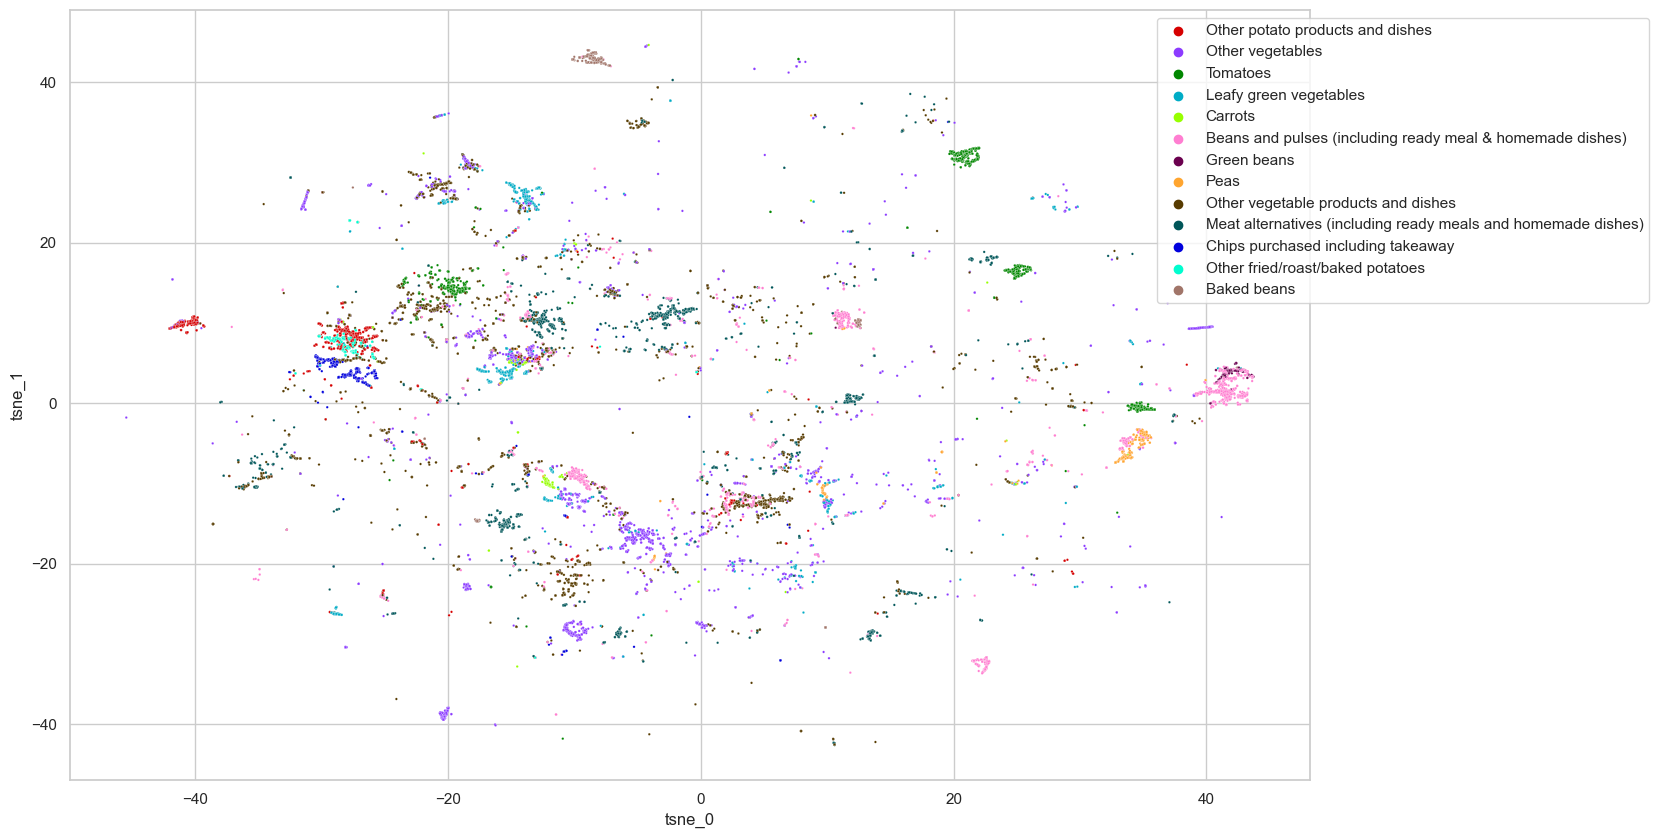

In [35]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pred['tsne_0'], y=pred['tsne_1'],
    hue=pred['subfoodgroup_pred'],
    palette=sns.color_palette(cc.glasbey, n_colors=pred['subfoodgroup_pred'].nunique()), s=3
)
plt.legend(bbox_to_anchor=(1.28, 1), loc='upper right')

In [36]:
# save level 2 cereal categories
pred.to_csv('../../future_of_food/NDNS UK/predictions/predictions_veg_lev2_manuallabels_nonHI_RF_15Oct2024.csv', 
                      index=False)